In [1]:
from config import MARKET_MODEL_DIR,MARKET_MODEL_DIR_TESTING
from model_factory import build_market_neutral_model, build_market_neutral_model_testing
import pickle
with open(MARKET_MODEL_DIR, "rb") as f:
    params = pickle.load(f)

with open(MARKET_MODEL_DIR_TESTING, "rb") as f:
    params_testing = pickle.load(f)
    
import os
#个人许可证
#os.environ['GRB_LICENSE_FILE'] = os.path.expanduser("~/gurobi/gurobi.lic")


## 系统Gurobi
os.environ['GUROBI_HOME'] = '/usr/licensed/gurobi/12.0.0/linux64'
os.environ['GRB_LICENSE_FILE'] = '/usr/licensed/gurobi/license/gurobi.lic'

# 清除个人WLS许可证
for var in ['WLSACCESSID', 'WLSSECRET']:
    if var in os.environ:
        del os.environ[var]

model = build_market_neutral_model(**params)
model_testing= build_market_neutral_model_testing(**params_testing)

Using device: cuda
GPU: NVIDIA A100 80GB PCIe MIG 1g.10gb
Set parameter LicenseID to value 197246
Set parameter GURO_PAR_SPECIAL
Set parameter TokenServer to value "license.rc.princeton.edu"


In [2]:
from config import DATASET_DICT_PATH, TEST_DATASET_DICT_PATH
from io_utils import load_dataset_dict, create_dataset_from_dict
dataset_dict = load_dataset_dict(DATASET_DICT_PATH)
dataset_train = create_dataset_from_dict(dataset_dict, model)

>>> Precomputed mode enabled. Skipping time series processing and solution computation.


In [3]:
test_dataset_dict = load_dataset_dict(TEST_DATASET_DICT_PATH)
dataset_test = create_dataset_from_dict(test_dataset_dict, model)

>>> Precomputed mode enabled. Skipping time series processing and solution computation.


In [4]:
from config import K, HIDDEN_DIM, LSTM_HIDDEN_DIM, DROPOUT_RATE, DEVICE
from architecture import TwoLayerLSTM
from seed import set_seed

set_seed(42)
lstm = TwoLayerLSTM(k=K, hidden_dim=HIDDEN_DIM, lstm_hidden_dim=LSTM_HIDDEN_DIM, dropout_rate=DROPOUT_RATE).to(DEVICE)
print("Model architecture:")
for name, param in lstm.named_parameters():
    print(f"{name:30s} | Shape: {param.data.shape} | Parameters: {param.numel()} | require_grad: {param.requires_grad}")
    print(f"Mean Value: {param.data.mean()} | Grad: {param.grad}")
    print("-" * 80)

Seed set to 42
Model architecture:
lstm.weight_ih_l0              | Shape: torch.Size([256, 6]) | Parameters: 1536 | require_grad: True
Mean Value: -0.0016327120829373598 | Grad: None
--------------------------------------------------------------------------------
lstm.weight_hh_l0              | Shape: torch.Size([256, 64]) | Parameters: 16384 | require_grad: True
Mean Value: -9.670818690210581e-05 | Grad: None
--------------------------------------------------------------------------------
lstm.bias_ih_l0                | Shape: torch.Size([256]) | Parameters: 256 | require_grad: True
Mean Value: 0.00032716424902901053 | Grad: None
--------------------------------------------------------------------------------
lstm.bias_hh_l0                | Shape: torch.Size([256]) | Parameters: 256 | require_grad: True
Mean Value: -0.0032916220370680094 | Grad: None
--------------------------------------------------------------------------------
fc_layers.0.weight             | Shape: torch.Size(

In [5]:
from data_loader import get_data_loaders
# 创建 Subset 类
from torch.utils.data import DataLoader
from config import BATCH_SIZE
# 假设 dataset_train, dataset_test 都是 optDataset 的实例
loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
loader_test  = DataLoader(dataset_test,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

loader_train, loader_test = get_data_loaders(dataset_train, dataset_test)

loss_log=[]
loss_log_regret=[]

In [6]:
from train import trainModel
from config import NUM_EPOCHS, BATCH_SIZE, LR, LSTM_SAVE_DIR
import os
os.makedirs(LSTM_SAVE_DIR, exist_ok=True)   
import pyepo
import torch 

set_seed(42)

spop = pyepo.func.SPOPlus(model)
loss_log, loss_log_regret = trainModel(
    lstm, 
    loss_func=spop, 
    method_name="spo+",
    loader_train=loader_train,
    loader_test=loader_test,
    market_neutral_model=model,
    params_testing=params_testing,
    loss_log=loss_log, 
    loss_log_regret=loss_log_regret,
    num_epochs=NUM_EPOCHS,  # Increased for better convergence
    lr=LR,
    initial=True# Adjusted learning rate
)

lstm_save_path = os.path.join(LSTM_SAVE_DIR, "trial_335_assets.pt")
torch.save({
    'model_state_dict': lstm.state_dict(),
    'loss_log': loss_log,
    'loss_log_regret': loss_log_regret
}, lstm_save_path)

print(f"模型参数已保存到 {lstm_save_path}")

Seed set to 42
Num of cores: 1


Testing Regret: 3276batch [14:22,  3.80batch/s]


Initial regret: 111.0607%


Epoch 1/3: 100%|██████████| 13101/13101 [17:41<00:00, 12.34it/s, loss=0.0350, batch time=0.0776s]
Testing Regret: 3276batch [16:14,  3.36batch/s]


Epoch 1: Loss=0.031162, Regret=104.8295%, Time=2035.93s


Epoch 2/3: 100%|██████████| 13101/13101 [17:41<00:00, 12.34it/s, loss=0.0239, batch time=0.0771s]
Testing Regret: 3276batch [14:24,  3.79batch/s]


Epoch 2: Loss=0.029800, Regret=110.5038%, Time=1925.88s


Epoch 3/3: 100%|██████████| 13101/13101 [17:14<00:00, 12.66it/s, loss=0.0299, batch time=0.0767s]
Testing Regret: 3276batch [14:15,  3.83batch/s]

Epoch 3: Loss=0.030074, Regret=99.5494%, Time=1890.65s
Total training time: 5852.47s, Effective computation time: 3046.54s
模型参数已保存到 ./lstm/trial_335_assets.pt


In [7]:
from train import trainModel
from config import NUM_EPOCHS, BATCH_SIZE, LR, LSTM_SAVE_DIR
import os
os.makedirs(LSTM_SAVE_DIR, exist_ok=True)   
import pyepo
import torch 

set_seed(42)

spop = pyepo.func.SPOPlus(model)
loss_log, loss_log_regret = trainModel(
    lstm, 
    loss_func=spop, 
    method_name="spo+",
    loader_train=loader_train,
    loader_test=loader_test,
    market_neutral_model=model,
    params_testing=params_testing,
    loss_log=loss_log, 
    loss_log_regret=loss_log_regret,
    num_epochs=NUM_EPOCHS,  # Increased for better convergence
    lr=LR,
    initial=False# Adjusted learning rate
)

lstm_save_path = os.path.join(LSTM_SAVE_DIR, "trial_335_assets.pt")
torch.save({
    'model_state_dict': lstm.state_dict(),
    'loss_log': loss_log,
    'loss_log_regret': loss_log_regret
}, lstm_save_path)

print(f"模型参数已保存到 {lstm_save_path}")

Seed set to 42
Num of cores: 1


Epoch 1/3: 100%|██████████| 13101/13101 [17:24<00:00, 12.55it/s, loss=0.0228, batch time=0.0783s]
Testing Regret: 3276batch [15:01,  3.63batch/s]


Epoch 1: Loss=0.031407, Regret=110.9481%, Time=1945.93s


Epoch 2/3: 100%|██████████| 13101/13101 [17:38<00:00, 12.37it/s, loss=0.0284, batch time=0.0780s]
Testing Regret: 3276batch [15:36,  3.50batch/s]


Epoch 2: Loss=0.031241, Regret=99.7639%, Time=1995.67s


Epoch 3/3: 100%|██████████| 13101/13101 [17:38<00:00, 12.38it/s, loss=0.0359, batch time=0.0785s]
Testing Regret: 3276batch [15:02,  3.63batch/s]

Epoch 3: Loss=0.030803, Regret=109.4721%, Time=1961.45s
Total training time: 5903.04s, Effective computation time: 3053.95s
模型参数已保存到 ./lstm/trial_335_assets.pt


In [8]:
from train import trainModel
from config import NUM_EPOCHS, BATCH_SIZE, LR, LSTM_SAVE_DIR
import os
os.makedirs(LSTM_SAVE_DIR, exist_ok=True)   
import pyepo
import torch 

set_seed(42)

spop = pyepo.func.SPOPlus(model)
loss_log, loss_log_regret = trainModel(
    lstm, 
    loss_func=spop, 
    method_name="spo+",
    loader_train=loader_train,
    loader_test=loader_test,
    market_neutral_model=model,
    params_testing=params_testing,
    loss_log=loss_log, 
    loss_log_regret=loss_log_regret,
    num_epochs=NUM_EPOCHS,  # Increased for better convergence
    lr=LR,
    initial=False# Adjusted learning rate
)

lstm_save_path = os.path.join(LSTM_SAVE_DIR, "trial_335_assets.pt")
torch.save({
    'model_state_dict': lstm.state_dict(),
    'loss_log': loss_log,
    'loss_log_regret': loss_log_regret
}, lstm_save_path)

print(f"模型参数已保存到 {lstm_save_path}")

Seed set to 42
Num of cores: 1


Epoch 1/3: 100%|██████████| 13101/13101 [17:29<00:00, 12.48it/s, loss=0.0221, batch time=0.0831s]
Testing Regret: 3276batch [14:09,  3.86batch/s]


Epoch 1: Loss=0.033032, Regret=110.9515%, Time=1899.64s


Epoch 2/3: 100%|██████████| 13101/13101 [17:27<00:00, 12.51it/s, loss=0.0318, batch time=0.0755s]
Testing Regret: 3276batch [14:57,  3.65batch/s]


Epoch 2: Loss=0.031888, Regret=106.9036%, Time=1944.77s


Epoch 3/3: 100%|██████████| 13101/13101 [17:24<00:00, 12.54it/s, loss=0.0355, batch time=0.0778s]
Testing Regret: 3276batch [14:45,  3.70batch/s]

Epoch 3: Loss=0.035721, Regret=100.2590%, Time=1930.82s
Total training time: 5775.23s, Effective computation time: 3029.06s
模型参数已保存到 ./lstm/trial_335_assets.pt


In [9]:
from train import trainModel
from config import NUM_EPOCHS, BATCH_SIZE, LR, LSTM_SAVE_DIR
import os
os.makedirs(LSTM_SAVE_DIR, exist_ok=True)   
import pyepo
import torch 

set_seed(42)

spop = pyepo.func.SPOPlus(model)
loss_log, loss_log_regret = trainModel(
    lstm, 
    loss_func=spop, 
    method_name="spo+",
    loader_train=loader_train,
    loader_test=loader_test,
    market_neutral_model=model,
    params_testing=params_testing,
    loss_log=loss_log, 
    loss_log_regret=loss_log_regret,
    num_epochs=NUM_EPOCHS,  # Increased for better convergence
    lr=LR,
    initial=False# Adjusted learning rate
)

lstm_save_path = os.path.join(LSTM_SAVE_DIR, "trial_335_assets.pt")
torch.save({
    'model_state_dict': lstm.state_dict(),
    'loss_log': loss_log,
    'loss_log_regret': loss_log_regret
}, lstm_save_path)

print(f"模型参数已保存到 {lstm_save_path}")

Seed set to 42
Num of cores: 1


Epoch 1/3: 100%|██████████| 13101/13101 [17:15<00:00, 12.65it/s, loss=0.0228, batch time=0.0768s]
Testing Regret: 3276batch [15:09,  3.60batch/s]


Epoch 1: Loss=0.037241, Regret=106.3099%, Time=1945.74s


Epoch 2/3: 100%|██████████| 13101/13101 [16:55<00:00, 12.90it/s, loss=0.0325, batch time=0.0752s]
Testing Regret: 3276batch [13:25,  4.07batch/s]


Epoch 2: Loss=0.039587, Regret=108.9321%, Time=1821.27s


Epoch 3/3:  50%|█████     | 6563/13101 [08:21<08:19, 13.09it/s, loss=0.0307, batch time=0.0737s] 


GurobiError: Element 250 of a double array is Nan or Inf.


Visualizing learning curves...


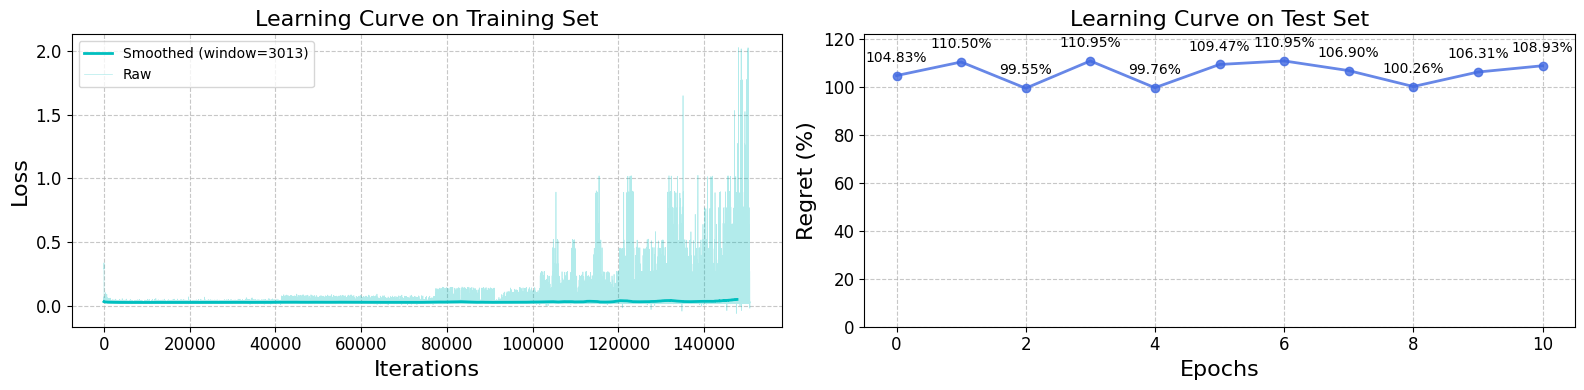

In [10]:
#############################################################################
# VISUALIZATION
#############################################################################
from matplotlib import pyplot as plt
import numpy as np


def visLearningCurve(loss_log, loss_log_regret):
    """Enhanced visualization with smoother curves and more information"""
    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
    
    # Plot training loss with smoothing for readability
    n_points = len(loss_log)
    
    # Apply smoothing for large datasets
    if n_points > 100:
        window_size = max(10, n_points // 50)
        smoothed_loss = np.convolve(loss_log, np.ones(window_size)/window_size, mode='valid')
        x_axis = np.arange(len(smoothed_loss))
        ax1.plot(x_axis, smoothed_loss, color="c", lw=2, label=f"Smoothed (window={window_size})")
        # Also plot the raw data with transparency
        ax1.plot(loss_log, color="c", lw=0.5, alpha=0.3, label="Raw")
        ax1.legend()
    else:
        # For smaller datasets, just plot the raw data
        ax1.plot(loss_log, color="c", lw=2)
    
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iterations", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Learning Curve on Training Set", fontsize=16)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Draw plot for regret on test set
    epochs = np.arange(len(loss_log_regret))
    ax2.plot(epochs, [r*100 for r in loss_log_regret], 
             color="royalblue", marker='o', ls="-", alpha=0.8, lw=2)
    
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_ylim(0, max(50, max([r*100 for r in loss_log_regret])*1.1))  # Dynamic y-limit
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret (%)", fontsize=16)
    ax2.set_title("Learning Curve on Test Set", fontsize=16)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # Add values to points
    for i, r in enumerate(loss_log_regret):
        ax2.annotate(f"{r*100:.2f}%", 
                     (i, r*100),
                     textcoords="offset points", 
                     xytext=(0,10), 
                     ha='center')
    
    plt.tight_layout()
    # plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
    # print("Saved learning curves to 'learning_curves.png'")
    plt.show()

print("\nVisualizing learning curves...")
visLearningCurve(loss_log, loss_log_regret)

### 回测

In [11]:
from train import trainModel
from config import NUM_EPOCHS, BATCH_SIZE, LR, LSTM_SAVE_DIR
import pyepo
import torch 
import os

lstm_save_path = os.path.join(LSTM_SAVE_DIR, "trial_335_assets.pt")
lstm_eval = TwoLayerLSTM(k=K, hidden_dim=HIDDEN_DIM, lstm_hidden_dim=LSTM_HIDDEN_DIM, dropout_rate=DROPOUT_RATE).to(DEVICE)
checkpoint = torch.load(lstm_save_path, map_location=DEVICE, weights_only=False)
lstm_eval.load_state_dict(checkpoint['model_state_dict'])
print("Model architecture after training:")
for name, param in lstm_eval.named_parameters():
    print(f"{name:30s} | Shape: {param.data.shape} | Parameters: {param.numel()} | require_grad: {param.requires_grad}")
    print(f"Mean Value: {param.data.mean()} | Grad: {param.grad}")
    print("-" * 80)

Model architecture after training:
lstm.weight_ih_l0              | Shape: torch.Size([256, 6]) | Parameters: 1536 | require_grad: True
Mean Value: 0.0064962320029735565 | Grad: None
--------------------------------------------------------------------------------
lstm.weight_hh_l0              | Shape: torch.Size([256, 64]) | Parameters: 16384 | require_grad: True
Mean Value: 0.020544257014989853 | Grad: None
--------------------------------------------------------------------------------
lstm.bias_ih_l0                | Shape: torch.Size([256]) | Parameters: 256 | require_grad: True
Mean Value: -0.2915639281272888 | Grad: None
--------------------------------------------------------------------------------
lstm.bias_hh_l0                | Shape: torch.Size([256]) | Parameters: 256 | require_grad: True
Mean Value: -0.2951180934906006 | Grad: None
--------------------------------------------------------------------------------
fc_layers.0.weight             | Shape: torch.Size([64]) | P

In [12]:
import numpy as np
# set lstm to evaluation mode
lstm_eval.eval()

pred_returns = [] # predicted returns
with torch.no_grad():
    for x, _, _, _ in loader_test:
        # 1. 预测 returns
        x = x.to(DEVICE)                      # (batch_size, N, lookback, k)
        pred_return = lstm_eval(x)                   # (batch_size, N)
        pred_return = pred_return.cpu().numpy()             # 转成ndarray
        pred_returns.append(pred_return)

pred_returns = np.vstack(pred_returns) # (T, N)
print(f"预测的收益率矩阵形状是: {pred_returns.shape}")

预测的收益率矩阵形状是: (26202, 335)


In [13]:
feats_test = np.load("test_data/features_crypto_data.npy")
print(f"测试集feature的形状是: {feats_test.shape}")

测试集feature的形状是: (26202, 335, 6)


In [14]:
### 优化器
from config import PRECOMPUTE_BATCH_SIZE, LOOKBACK, PADDING_METHOD
from batch_runner import process_and_combine_shared


#dataset_dict_test = process_and_combine_shared(feats_test, pred_returns, batch_size=PRECOMPUTE_BATCH_SIZE, **params)
from test_regret import sequential_solutions

positions=sequential_solutions(predmodel=lstm_eval,params_testing=params_testing, dataloader=loader_test)

Testing Solutions: 100%|██████████| 3276/3276 [08:56<00:00,  6.11batch/s]


In [15]:
# 测试集仓位
#positions = dataset_dict_test["sols"]
positions=np.array(positions)
print(f"测试集仓位的形状是: {positions.shape}")

测试集仓位的形状是: (26202, 335)


In [16]:
pnl_series = []
for i in range(len(positions)):
    pnl = np.nansum(positions[i] * test_dataset_dict["costs"][i])
    pnl_series.append(pnl)
print(f"pnl series的长度是: {len(pnl_series)}")

pnl series的长度是: 26202


### Visualize Cumulative Pnl

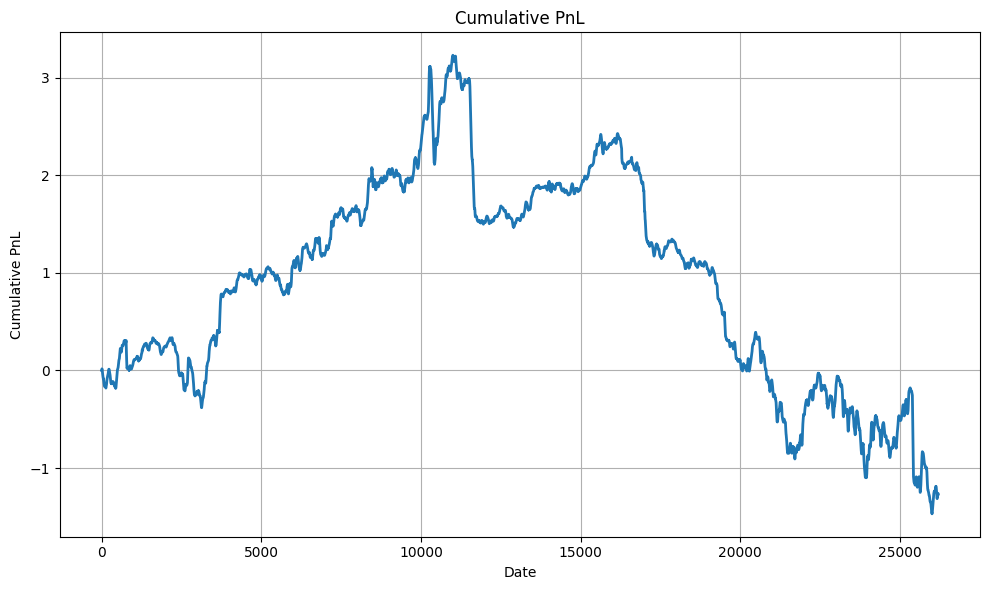

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_cum_pnl_series(pnl_series, title='Cumulative PnL', figsize=(10, 6)):
    """
    绘制累计 PnL 曲线。

    参数
    -----
    pnl_series : pandas.Series
        每期的 PnL 序列，索引为日期或时间点。
    title : str, optional
        图表标题，默认 'Cumulative PnL'。
    figsize : tuple, optional
        图表大小，默认为 (10, 6)。
    """
    # 计算累计 PnL
    cum_pnl = pd.Series(pnl_series).cumsum()

    # 绘图
    plt.figure(figsize=figsize)
    plt.plot(np.arange(len(cum_pnl)), cum_pnl.values, linewidth=2)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Cumulative PnL')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_cum_pnl_series(pnl_series)
